# AdaBoost

AdaBoost is short for adaptive boosting. AdaBoost trains a series of weak learners, with each subsequent classifier paying more attention to the training instances that were misclassified by its predecessors.

## What we will accomplish

In this notebook we will:
- Discuss the theoretical foundation of the AdaBoost algorithm,
- Demonstrate how to implement AdaBoost in `sklearn` and
- Provide references for you to learn more about AdaBoost.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

## How it works

AdaBoost (short for adaptive boosting) is an algorithm that builds a strong learner with an iterative sequence of weak learners.  While the ideas can be applied more generally we will address the case of binary classification.

Let $\mathcal{D} = (x_i,y_i)$ with $i = 1,2,3,...,N$ be our training data, with $x_i \in \mathbb{R}^p$ and $y_i \in \{-1,1\}$.  Let $X = \{x_i\}$.  Suppose that we have a parameterized collection of classifiers $C_\theta: \mathbb{R}^p \to \{-1,1\}$.  A common choice in AdaBoost is for $C_{j,t, \pm}$ to be a decision stump on feature $j$ with threshold $t$ (i.e. classify as $1$ if $\pm x_j > t$ and $-1$ else).

Our goal is to build a function $f : \mathbb{R}^p \to \mathbb{R}$ where $f(x) >> 0$ represents great confidence that $y = 1$ and $f(x) << 0$ represents great condidence that $y = -1$ (we will quantify this with a loss function soon).  We will build this function as a linear combination of weak classifiers:

$$
f = \sum_1^m \beta_j C_j
$$

Our goal is to minimize the exponential loss function

$$
L(f, y) = \sum_{1}^N \exp(-y_i f(x_i))
$$

A few notes about this loss function:

1. Each term is small when $y_i$ and $f(x_i)$ have the same sign, and $|f(x_i)|$ is large.
2. For a given $x$, assume that $(Y|x)$ is a Bernoulli random variable with probability $p$ of $Y=1$ and $(1-p)$ of $Y=-1$.  Then the value of $f(x)$ which minimizes the expected value of $\exp(-Yf(x))$ is $\frac{1}{2} \log\left( \frac{p}{1-p}\right)$.  So the population minimizer of $f(x)$ is half the log-odds of $(Y|x)$.

This is really cool:  we are building a probabilistic classifier out of a bunch of non-probabilistic classifiers. 

We approximate the minimizer $f$ using "forward stagewise addititve modeling": 

1. Select $\beta_1 = 1$ and $C_1$ to minimize $L(C_1, y_i)$.  Set $f_1 = C_1$. 
2. At stage $j > 1$ we will select $(\beta_m, C_m)$ to minimize $L(f_j, y_i)$ where $f_j = f_{j-1} + \beta_m C_j$.

Since 

$$
\begin{align*}
L(f_j, y_i) &= \sum_{1}^N \exp(-y_i f_{j-1}(x_i) - \beta_m y_i C_j(x_i))\\
            &= \sum_{1}^N \exp(-y_i f_{j-1}(x_i))\exp(- \beta_m y_i C_j(x_i))\\
            &= \sum_{1}^N w_i \exp(- \beta_m y_i C_j(x_i))\\
\end{align*}
$$

where $w_i^j = \exp(-y_i f_{j-1}(x_i))$ doesn't depend on $m$ or $C_m$, and so can be thought of as a weighting on the *samples* at stage $j$.

With a little Calculus one can show that for the $(\beta_j, C_j)$ pair which minimizes the loss:

* $C_j$ minimizes the *weighted error rate* 

$$\operatorname{err}_j = \frac{\displaystyle\sum_1^N w_i^j \mathbb{1}_{ C_j(x_i) \neq y_i}}{\displaystyle \sum_1^N w_i^j}$$

* $\beta_j = \frac{1}{2} \log(\frac{1 - \operatorname{err}_j}{\operatorname{err}_j})$ 

Note that the weighted error rate compels us to choose a classifier $C_j$ which "pays more attention" to those training examples which we were "confidently incorrect" about in the last stage.  A smaller $\operatorname{err}_j$ gives a larger $\beta_j$.

## In `sklearn`

Let's now demonstrate how to implement this algorithm as a classifier in `sklearn` with `AdaBoostClassifier`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html</a>. <i>For an adaptive boosting regression model check out `AdaBoostRegressor`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html">https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html</a>.</i>

In [2]:
np.random.seed(216)

n_samples = 1000
X = np.random.uniform(low = -2, high = 2, size=(n_samples,2))

y = np.zeros(n_samples)
y[((X[:,0]-1)**2 +X[:,1]**2 > 1) & (X[:,0]**2 + X[:,1]**2 < 4)] = 1
y[((X[:,0]-1)**2 +X[:,1]**2 < 1)] = 2

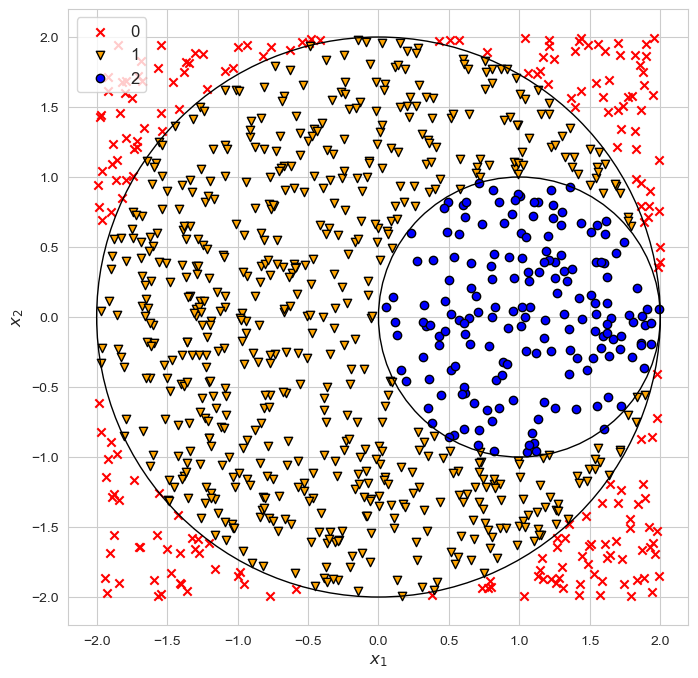

In [3]:
plt.figure(figsize = (8,8))

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue', label = "2")
plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))

plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)
plt.legend(fontsize=12, loc=2)

plt.show()

For our weak learner we will use a shallow decision tree.

In [ ]:
## Import AdaBoost
from sklearn.ensemble import AdaBoostClassifier

## Import the base classifier.  We will use a decision tree classifier. 
from sklearn.tree import DecisionTreeClassifier

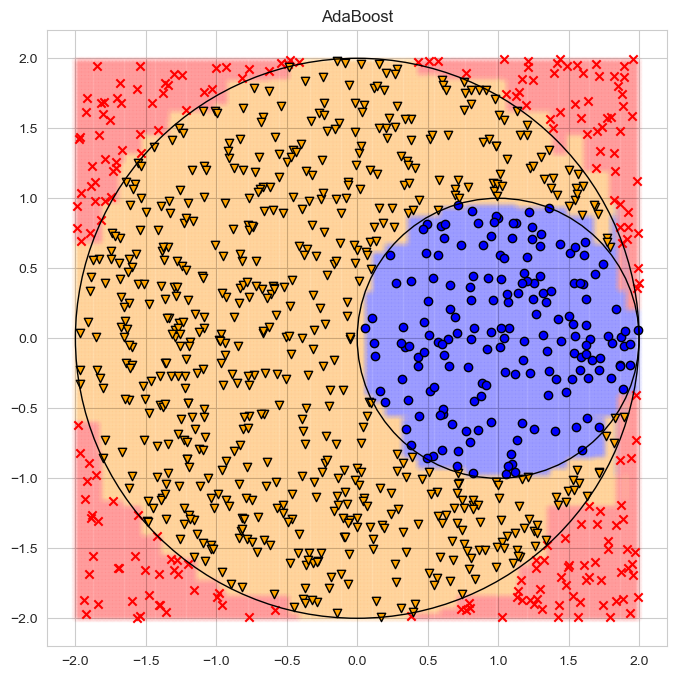

In [5]:
    # n_estimators controls how many weak learners we use
    # learning_rate is a hyperparameter that controls how
    # aggressively we correct incorrect labels
    # algorithm is the algorithm that sklearn runs to fit the model
    # SAMME.R or SAMME are the options, SAMME.R allows calculation
    # of probabilities.

xx1, xx2 = np.meshgrid(np.arange(-2, 2, .01),
                          np.arange(-2, 2, .01))

X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
X_pred[:,0] = xx1.flatten()
X_pred[:,1] = xx2.flatten()

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                                n_estimators=100,
                                algorithm = 'SAMME',
                                learning_rate = 0.5,
                                random_state=123)

# fit the classifier
ada_clf.fit(X, y)

# make some predictions
preds = ada_clf.predict(X_pred)

s = 25

## this plots the resulting decision boundary ##
plt.figure(figsize=(8,8))
plt.scatter(X_pred[preds==0,0],
            X_pred[preds==0,1],
            alpha=.01,
            c='red',
            s=s)
plt.scatter(X_pred[preds==1,0],
            X_pred[preds==1,1],
            alpha=.01,
            c='orange',
            s=s)
plt.scatter(X_pred[preds==2,0],
            X_pred[preds==2,1],
            alpha=.01,
            c='blue',
            s=s)

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue',label = "2",alpha=1)

plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))

plt.title("AdaBoost")
plt.show()

    


### References

Some additional references on AdaBoost models can be found below:

<a href = "http://rob.schapire.net/papers/Schapire99c.pdf">A Brief Introduction to Boosting</a> by Robert E. Schapire

<a href = "https://doc.lagout.org/science/0_Computer%20Science/2_Algorithms/Boosting_%20Foundations%20and%20Algorithms%20%5BSchapire%20%26%20Freund%202012-05-18%5D.pdf">Boosting</a> by  Robert E. Schapire and Yoav Freund

<a href = "https://www.csie.ntu.edu.tw/~mhyang/course/u0030/papers/schapire.pdf">A Boosting Tutorial</a> by Robert E.  Schapire

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erd≈ës Institute as subject to the license (see License.md)